In [ ]:
!pip install tensorflow==2.16.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.7/590.7 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.16.2 w

## Importing Libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Add, Dropout, Resizing, Rescaling, InputLayer, Flatten, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomContrast
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# HyperParameters

In [ ]:
# Hyperparameters
learning_rate = 0.0002
class_name = ['glioma', 'meningioma', 'notumor', 'pituitary']
weight_decay = 0.0001
num_classes = 4
batch_size = 32
num_epochs = 100
image_size = 256
patch_size = 16
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
Num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
num_layers = 18
Hidden_size = 64
mlp_head_units = 1024


## Mount Drive and Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/Training'
test_path = '/content/drive/MyDrive/Testing/Testing'

In [ ]:
# Load Datasets
###########################################
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path, labels='inferred', label_mode='categorical',
    color_mode='grayscale', batch_size=batch_size,
    image_size=(image_size, image_size), shuffle=True, seed=99
)

train_class_names = train_dataset.class_names
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path, labels='inferred', label_mode='categorical',
    color_mode='grayscale', batch_size=batch_size,
    image_size=(image_size, image_size), shuffle=True, seed=99
)

test_class_names = test_dataset.class_names
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Training Classes:", train_class_names)
print("Testing Classes:", test_class_names)


Found 5720 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Training Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Testing Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## Pre-processing and Augmentation

In [ ]:
# Data Preprocessing and Augmentation
###########################################
augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

## Visualize data

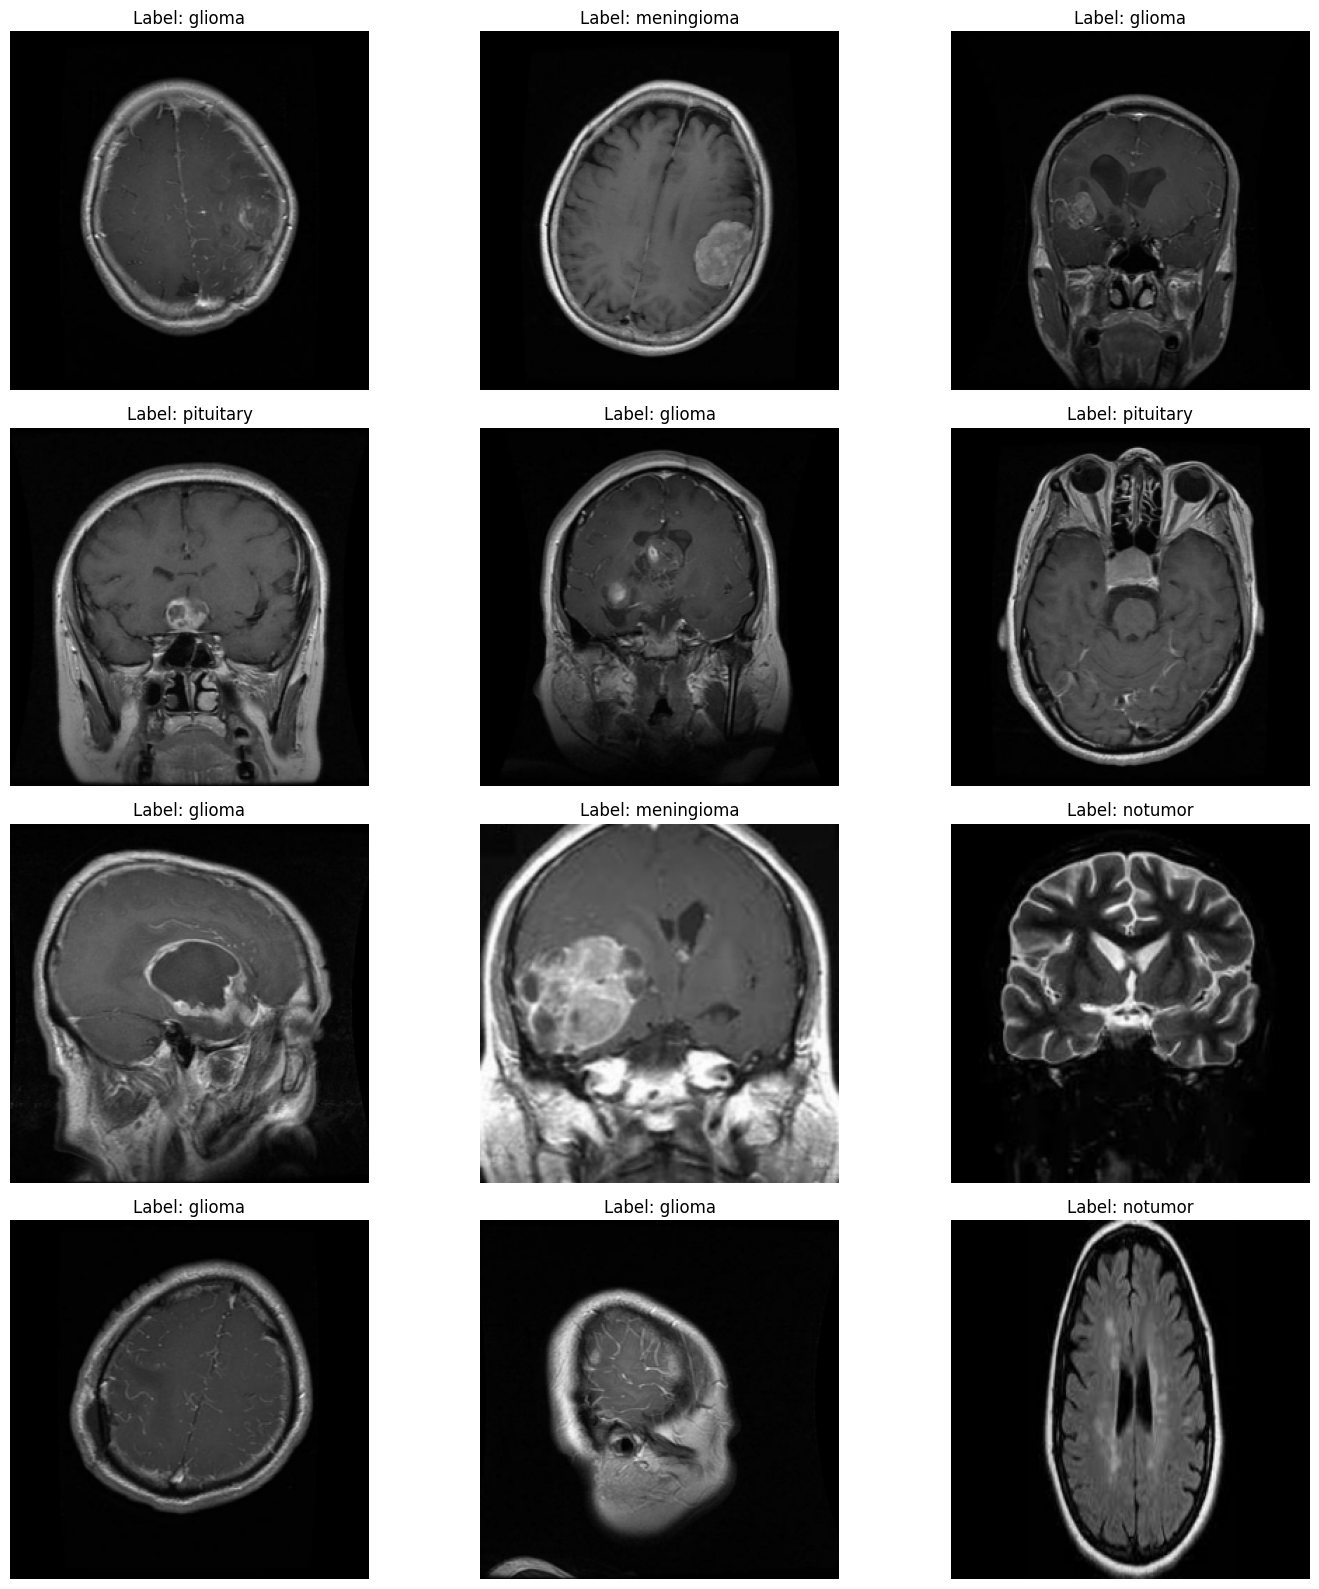

In [ ]:
# Visualize Dataset
###########################################
num_images = 12  # Total images to display
rows = 4  # Number of rows
cols = 3  # Number of columns

batch_images, batch_labels = next(iter(train_dataset))

plt.figure(figsize=(15, 16))

for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(batch_images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(f'Label: {class_name[tf.argmax(batch_labels[i])]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


## ViT Components

In [ ]:
# Patch Encoder
###########################################
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, patch_size, Hidden_size):
        super(PatchEncoder, self).__init__()
        self.projection = Dense(Hidden_size)
        self.position_embedding = tf.keras.layers.Embedding(input_dim=num_patches, output_dim=Hidden_size)

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        positions = tf.range(start=0, limit=num_patches, delta=1)
        return self.projection(patches) + self.position_embedding(positions)

###########################################
# Transformer Encoder
###########################################
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, Num_heads, Hidden_size, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.layer_norm_1 = LayerNormalization()
        self.attention = MultiHeadAttention(num_heads=Num_heads, key_dim=Hidden_size)
        self.dropout_1 = Dropout(dropout_rate)
        self.layer_norm_2 = LayerNormalization()
        self.dense_1 = Dense(Hidden_size * 2, activation=tf.nn.gelu)
        self.dense_2 = Dense(Hidden_size, activation=tf.nn.gelu)
        self.dropout_2 = Dropout(dropout_rate)

    def call(self, inputs):
        x = self.layer_norm_1(inputs)
        attn_output = self.attention(x, x)
        x = self.dropout_1(attn_output) + inputs
        x_norm = self.layer_norm_2(x)
        x_ffn = self.dense_1(x_norm)
        x_ffn = self.dense_2(x_ffn)
        x = self.dropout_2(x_ffn) + x
        return x

###########################################
# Vision Transformer Model
###########################################
class VIT(tf.keras.Model):
    def __init__(self, Num_heads, Hidden_size, num_layers, mlp_head_units):
        super(VIT, self).__init__()
        self.patch_encoder = PatchEncoder(patch_size, Hidden_size)
        self.transformer_layers = [TransformerEncoder(Num_heads, Hidden_size) for _ in range(num_layers)]
        self.global_pool = GlobalAveragePooling1D()
        self.dense_1 = Dense(mlp_head_units, activation='relu')
        self.dropout = Dropout(0.5)
        self.output_layer = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        x = self.patch_encoder(inputs)
        for layer in self.transformer_layers:
            x = layer(x)
        x = self.global_pool(x)
        x = self.dense_1(x)
        x = self.dropout(x)
        return self.output_layer(x)

vit = VIT(Num_heads, Hidden_size, num_layers, mlp_head_units)
vit.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy(name='train_accuracy')]
)


## Train model

In [ ]:
# Custom Callback for Test Metrics
###########################################
class TestMetrics(Callback):
    def __init__(self, test_dataset):
        super(TestMetrics, self).__init__()
        self.test_dataset = test_dataset

    def on_epoch_end(self, epoch, logs=None):
        test_loss = 0
        test_accuracy = 0
        total_batches = 0

        for images, labels in self.test_dataset:
            preds = self.model(images, training=False)
            loss = tf.keras.losses.categorical_crossentropy(labels, preds)
            accuracy = tf.keras.metrics.categorical_accuracy(labels, preds)

            test_loss += tf.reduce_mean(loss)
            test_accuracy += tf.reduce_mean(accuracy)
            total_batches += 1

        test_loss /= total_batches
        test_accuracy /= total_batches

        logs['test_loss'] = test_loss
        logs['test_accuracy'] = test_accuracy
        print(f"Epoch {epoch + 1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

###########################################
# Train the Model
###########################################
history = vit.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=num_epochs,
    callbacks=[TestMetrics(test_dataset)]
)


Epoch 1/100
139/179 ━━━━━━━━━━━━━━━━━━━━ 38s 953ms/step - loss: 4.5508 - train_accuracy: 0.3951

## Plot Accuracy Graph

In [ ]:
#print(history.history.keys())


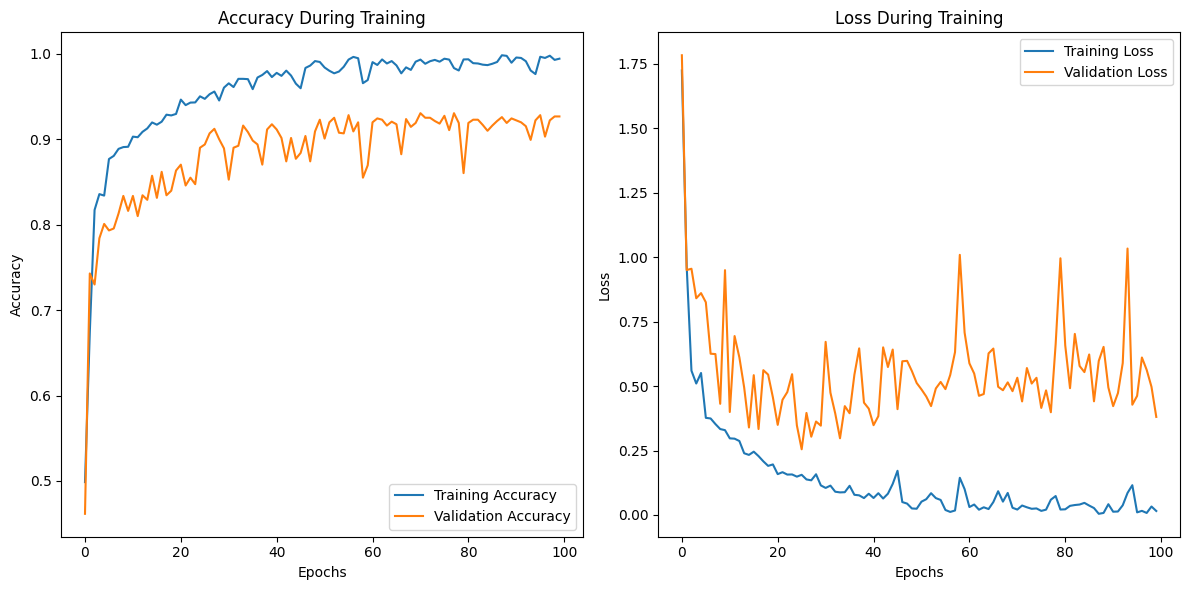

In [ ]:
plt.figure(figsize=(12, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['train_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_train_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy During Training')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss During Training')

plt.tight_layout()
plt.show()


## Confusuon Matrix and Classification Report

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

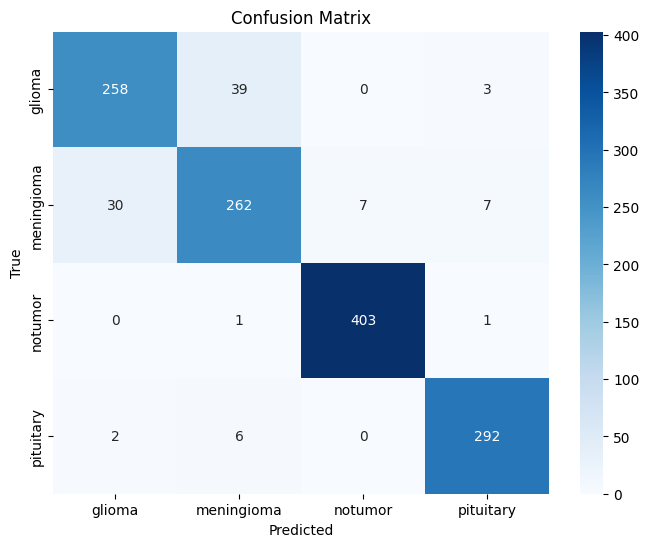

Classification Report in Tabular Format:
              precision    recall  f1-score      support
glioma         0.889655  0.860000  0.874576   300.000000
meningioma     0.850649  0.856209  0.853420   306.000000
notumor        0.982927  0.995062  0.988957   405.000000
pituitary      0.963696  0.973333  0.968491   300.000000
accuracy       0.926773  0.926773  0.926773     0.926773
macro avg      0.921732  0.921151  0.921361  1311.000000
weighted avg   0.926308  0.926773  0.926464  1311.000000
Overall Accuracy: 92.68%


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Initialize true and predicted label lists
y_true = []
y_pred = []

# Generate predictions
for images, labels in test_dataset:
    preds = vit.predict(images)
    y_true.extend(tf.argmax(labels, axis=1).numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_name, yticklabels=class_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_name, output_dict=True)
df = pd.DataFrame(report).transpose()
print("Classification Report in Tabular Format:")
print(df)

# Calculate and display overall accuracy
accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Overall Accuracy: {accuracy:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

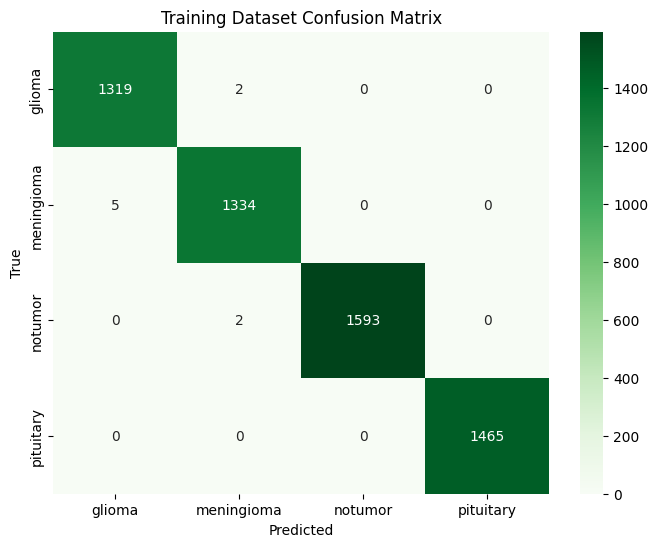

Training Dataset Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00      1321
  meningioma       1.00      1.00      1.00      1339
     notumor       1.00      1.00      1.00      1595
   pituitary       1.00      1.00      1.00      1465

    accuracy                           1.00      5720
   macro avg       1.00      1.00      1.00      5720
weighted avg       1.00      1.00      1.00      5720



In [ ]:
# Evaluate the model on the training dataset
train_y_true = []
train_y_pred = []

for images, labels in train_dataset:
    preds = vit.predict(images)
    train_y_true.extend(tf.argmax(labels, axis=1).numpy())
    train_y_pred.extend(tf.argmax(preds, axis=1).numpy())

# Confusion Matrix for Training Dataset
train_conf_matrix = confusion_matrix(train_y_true, train_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_name, yticklabels=class_name)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Training Dataset Confusion Matrix')
plt.show()

# Classification Report for Training Dataset
print("Training Dataset Classification Report:")
print(classification_report(train_y_true, train_y_pred, target_names=class_name))


In [ ]:
# Save the entire model
model_save_path = 'BrainViT_model.h5'
vit.save(model_save_path)
print(f'Model saved at: {model_save_path}')

Model saved at: BrainViT_model.h5


In [ ]:
from google.colab import files
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Function to preprocess the uploaded image
def preprocess_image(image_path, target_size=(256, 256)):
    img = tf.keras.utils.load_img(image_path, target_size=target_size, color_mode='grayscale')  # Load image
    img_array = tf.keras.utils.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to classify the image
def classify_image(model, image_array, class_names):
    predictions = model.predict(image_array)
    predicted_class_index = np.argmax(predictions)  # Index of the highest score
    predicted_class = class_names[predicted_class_index]  # Corresponding class name
    confidence = np.max(predictions)  # Confidence score
    return predicted_class, confidence

# Main loop to classify images
while True:
    print("\nUpload an image for classification or type 'stop' to exit.")
    user_input = input("Enter 'stop' to end or press Enter to upload: ").strip().lower()

    if user_input == "stop":
        print("Exiting image classification loop.")
        break

    # Upload and classify an image
    uploaded = files.upload()  # Use Colab's file upload feature

    for file_name in uploaded.keys():
        processed_image = preprocess_image(file_name, target_size=(256, 256))
        predicted_class, confidence = classify_image(vit, processed_image, class_name)

        # Display the uploaded image and classification result
        plt.imshow(np.squeeze(processed_image), cmap='gray')
        plt.title(f'Predicted: {predicted_class}, Confidence: {confidence:.2f}')
        plt.axis('off')
        plt.show()



Upload an image for classification or type 'stop' to exit.


KeyboardInterrupt: Interrupted by user